In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from auxiliary import plot_boundary, plot_svm_margins

sns.set()

# Support Vector Machines
## Clasificación

Para arrancar con el modelo SVM como clasificador (SVC), vamos a arrancar con datos sintéticos. Usamos un caso que no es linealmente separable

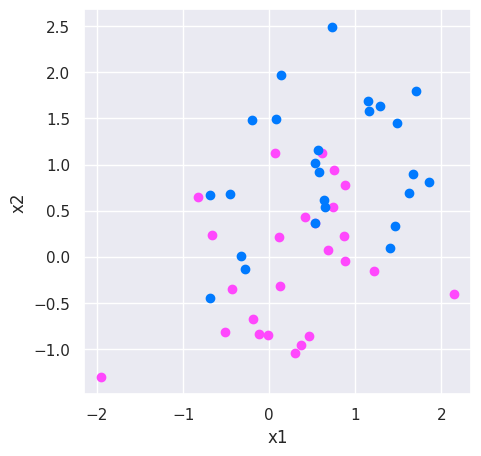

In [6]:
rng = np.random.default_rng(seed=42)

X = rng.standard_normal((50, 2)) 
y = np.array([-1]*25+[1]*25)
# Sumamos uno a la clase azul para desplazarlo 
X[y==1] += 1

fig, ax = plt.subplots(figsize=(5,5)) 
ax.scatter(X[:25,0], X[:25,1], c="#ff48fd")
ax.scatter(X[25:,0], X[25:,1], c="#007aff")
ax.set_xlabel("x1")
ax.set_ylabel("x2");

Creamos un modelo SVC usando [sklearn](https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html), definimos el caso lineal con C=10

In [7]:
from sklearn.svm import SVC

In [21]:
svm_linear = SVC(C=10, kernel='linear')
svm_linear.fit(X, y)

,C,10
,kernel,'linear'
,degree,3
,gamma,'scale'
,coef0,0.0
,shrinking,True
,probability,False
,tol,0.001
,cache_size,200
,class_weight,None
,verbose,False


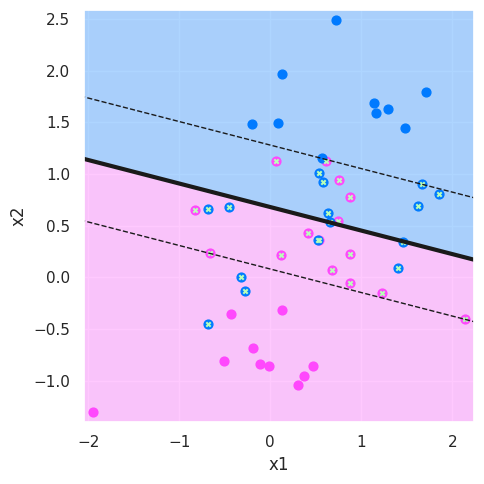

In [22]:
plot_boundary(X, y, svm_linear, 
              step_x=(0.01, 0.01),
              max_x=(0.1, 0.1),
              min_x=(-0.1, -0.1),
              colormap_frontier=('#ffb7fe', '#93c7ff'),
              colormap_points=('#ff48fd', '#007aff'),
              figsize=(5, 5),
              legend=False,
              point_size=40)
# Grafiquemos los vectores de soporte
plt.scatter(svm_linear.support_vectors_[:,0], svm_linear.support_vectors_[:,1], marker="x", color="#b8ffb7", s=10);

# Graficamos los bordes de decision
plot_svm_margins(X, svm_linear)

plt.tight_layout();

Veamos entrenar el modelo con un parámetro mas chico C=0.1

In [23]:
svm_linear_small = SVC(C=0.1, kernel='linear')
svm_linear_small.fit(X, y)

,C,0.1
,kernel,'linear'
,degree,3
,gamma,'scale'
,coef0,0.0
,shrinking,True
,probability,False
,tol,0.001
,cache_size,200
,class_weight,None
,verbose,False


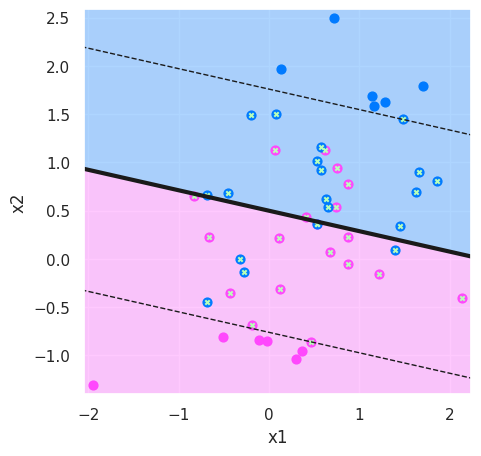

In [24]:
plot_boundary(X, y, svm_linear_small, 
              step_x=(0.01, 0.01),
              max_x=(0.1, 0.1),
              min_x=(-0.1, -0.1),
              colormap_frontier=('#ffb7fe', '#93c7ff'),
              colormap_points=('#ff48fd', '#007aff'),
              figsize=(5, 5),
              legend=False,
              point_size=40)
# Grafiquemos los vectores de soporte
plt.scatter(svm_linear_small.support_vectors_[:,0], svm_linear_small.support_vectors_[:,1], marker="x", color="#b8ffb7", s=10);

# Graficamos los bordes de decision
plot_svm_margins(X, svm_linear_small)

Con SVC lineales podemos obtener los coeficientes de la recta de decisión:

Aprovechemos este caso sencillo para hacer una optimización del hiperparámetro C usando [Grid Search](https://scikit-learn.org/stable/modules/grid_search.html#grid-search)

In [25]:
from sklearn.model_selection import GridSearchCV

svm_linear = SVC(kernel='linear')

grid = GridSearchCV(svm_linear,
                    {"C": [0.001, 0.01, 0.1, 1, 5, 10, 100]},
                    refit=True,
                    cv=5,
                    scoring='accuracy')
grid.fit(X,y)

,estimator,SVC(kernel='linear')
,param_grid,"{'C': [0.001, 0.01, ...]}"
,scoring,'accuracy'
,n_jobs,None
,refit,True
,cv,5
,verbose,0
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,C,0.1


Vemos que el mejor valor es cuando C=0.1

In [26]:
grid.best_params_

{'C': 0.1}

Podemos chusmear las metricas para cada caso:

In [27]:
grid.cv_results_['mean_test_score']

array([0.7 , 0.7 , 0.76, 0.74, 0.68, 0.68, 0.7 ])

In [28]:
grid.cv_results_['std_test_score']

array([0.08944272, 0.08944272, 0.10198039, 0.10198039, 0.04      ,
       0.04      , 0.06324555])

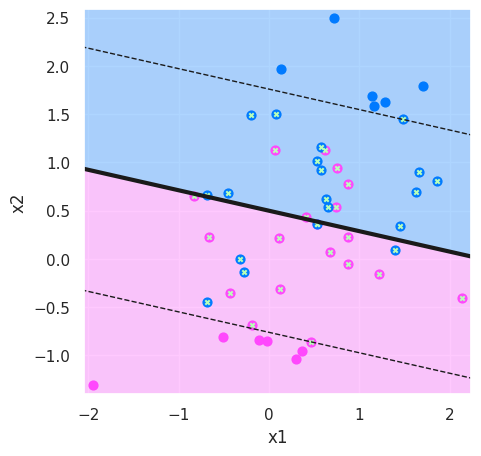

In [29]:
# No necesitamos entrenar el modelo porque con el parámetro refit de GridSearchCV ya lo entrenó por nosotros
svm_best = grid.best_estimator_

plot_boundary(X, y, svm_best, 
              step_x=(0.01, 0.01),
              max_x=(0.1, 0.1),
              min_x=(-0.1, -0.1),
              colormap_frontier=('#ffb7fe', '#93c7ff'),
              colormap_points=('#ff48fd', '#007aff'),
              figsize=(5, 5),
              legend=False,
              point_size=40)
# Grafiquemos los vectores de soporte
plt.scatter(svm_best.support_vectors_[:,0], svm_best.support_vectors_[:,1], marker="x", color="#b8ffb7", s=10);

# Graficamos los bordes de decision
plot_svm_margins(X, svm_best)

Con esto podemos predecir la clase de un set de testeo

In [30]:
X_test = rng.standard_normal((20, 2)) 
y_test = np.array([-1]*10+[1]*10) 
X_test[y_test==1] += 1

y_pred = svm_best.predict(X_test)

Evaluamos usando la matriz de confusión

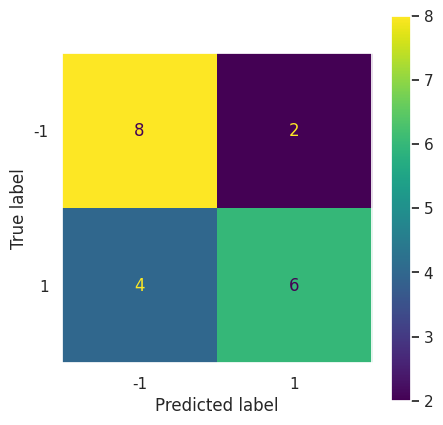

In [31]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(y_test, y_pred, labels=svm_best.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=svm_best.classes_)

fig, ax = plt.subplots(figsize=(5,5))
ax.grid(False)
disp.plot(ax=ax);

In [33]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

print(f"El porcentaje de accuracy es de:{accuracy_score(y_test, y_pred)*100: .0f}%")
print(f"El porcentaje de precision es de:{precision_score(y_test, y_pred)*100: .0f}%")
print(f"El porcentaje de recall es de:{recall_score(y_test, y_pred)*100: .0f}%")
print(f"El porcentaje de f1-score es de:{f1_score(y_test, y_pred)*100: .0f}%")

El porcentaje de accuracy es de: 70%
El porcentaje de precision es de: 75%
El porcentaje de recall es de: 60%
El porcentaje de f1-score es de: 67%


---

Veamos un caso que es linealmente separable

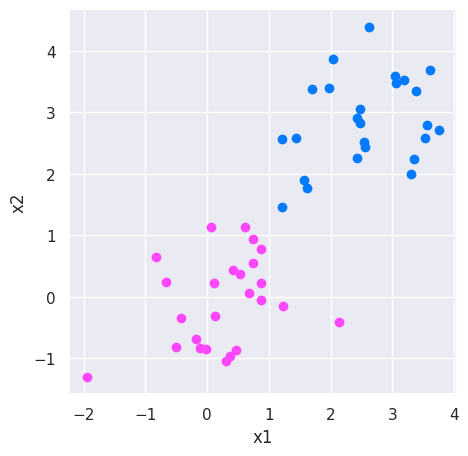

In [34]:
#Tomamos el caso sintentico anterior pero lo separamos mas
Xsep = X.copy()
Xsep[y==1] += 1.9

fig, ax = plt.subplots(figsize=(5,5)) 
ax.scatter(Xsep[:25,0], Xsep[:25,1], c="#ff48fd")
ax.scatter(Xsep[25:,0], Xsep[25:,1], c="#007aff")
ax.set_xlabel("x1")
ax.set_ylabel("x2");

Estamos en el caso de un modelo **Maximal Margin Classifier**, por lo que usamos un valor de C muy grande:

In [35]:
svm_separable = SVC(C=1e5, kernel='linear')
svm_separable.fit(Xsep, y)

,C,100000.0
,kernel,'linear'
,degree,3
,gamma,'scale'
,coef0,0.0
,shrinking,True
,probability,False
,tol,0.001
,cache_size,200
,class_weight,None
,verbose,False


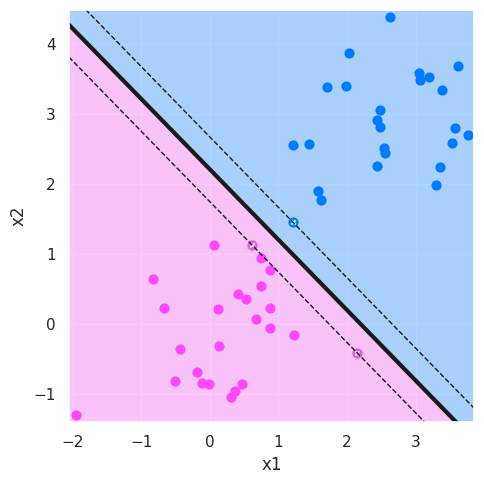

In [36]:
plot_boundary(Xsep, y, svm_separable, 
              step_x=(0.01, 0.01),
              max_x=(0.1, 0.1),
              min_x=(-0.1, -0.1),
              colormap_frontier=('#ffb7fe', '#93c7ff'),
              colormap_points=('#ff48fd', '#007aff'),
              figsize=(5, 5),
              legend=False,
              point_size=40)


# Grafiquemos los vectores de soporte
plt.scatter(svm_separable.support_vectors_[:,0], svm_separable.support_vectors_[:,1], marker="x", color="#b8ffb7", s=10);

# Graficamos los bordes de decision
plot_svm_margins(Xsep, svm_separable)

plt.tight_layout();

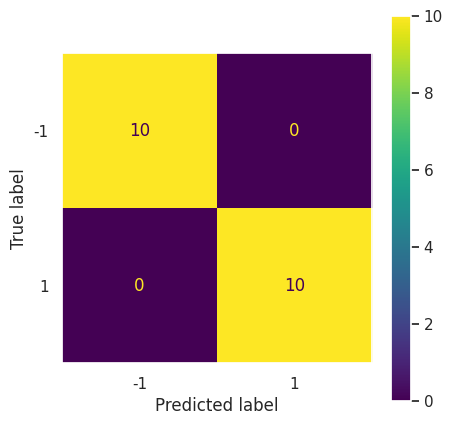

In [37]:
X_test[y_test==1] += 1.9
y_pred = svm_separable.predict(X_test)

cm = confusion_matrix(y_test, y_pred, labels=svm_separable.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=svm_best.classes_)

fig, ax = plt.subplots(figsize=(5,5))
ax.grid(False)
disp.plot(ax=ax);

## Uso de funciones Kernels

Veamos ahora cuando clasificamos con un modelo con una frontera de decision no lineal usando una funcion kernel. 

Empezamos con la función kernel polinomica, que tenemos como hiperparámetro, además de la C, el orden del polinomio, que en [SVC](https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html#sklearn.svm.SVC.decision_function) se pasa como  el argumento **gamma**. 

Pero, vamos a realizar primero una busqueda de posibles hiperparametro, tanto para C como para gamma usando **gridsearchCV**

In [38]:
svm_poly = SVC(kernel='poly')

grid = GridSearchCV(svm_poly,
                    {'C': [0.01, 0.1, 1, 5, 10, 100], 'degree': [2, 3, 4, 5]},
                    refit=True,
                    cv=5,
                    scoring='accuracy')
grid.fit(X, y)

,estimator,SVC(kernel='poly')
,param_grid,"{'C': [0.01, 0.1, ...], 'degree': [2, 3, ...]}"
,scoring,'accuracy'
,n_jobs,None
,refit,True
,cv,5
,verbose,0
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,C,1


In [39]:
# Vemos todos los datos de la busqueda como Dataframe que nos facilita la visualizacion
pd.DataFrame(grid.cv_results_).sort_values("rank_test_score")

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,param_degree,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
11,0.000390,0.000026,0.000372,0.000017,1.00,5,"{'C': 1, 'degree': 5}",0.7,0.8,0.8,0.7,0.7,0.74,0.048990,1
19,0.000486,0.000023,0.000399,0.000009,10.00,5,"{'C': 10, 'degree': 5}",0.8,0.7,0.8,0.7,0.7,0.74,0.048990,1
23,0.001115,0.000358,0.000423,0.000012,100.00,5,"{'C': 100, 'degree': 5}",0.8,0.7,0.7,0.7,0.7,0.72,0.040000,3
9,0.000395,0.000023,0.000389,0.000022,1.00,3,"{'C': 1, 'degree': 3}",0.7,0.8,0.8,0.7,0.6,0.72,0.074833,4
17,0.000452,0.000032,0.000407,0.000022,10.00,3,"{'C': 10, 'degree': 3}",0.7,0.6,0.8,0.7,0.7,0.70,0.063246,5
21,0.000729,0.000218,0.000422,0.000011,100.00,3,"{'C': 100, 'degree': 3}",0.7,0.8,0.8,0.6,0.6,0.70,0.089443,5
7,0.000420,0.000054,0.000386,0.000033,0.10,5,"{'C': 0.1, 'degree': 5}",0.8,0.8,0.7,0.6,0.6,0.70,0.089443,5
13,0.000439,0.000035,0.000433,0.000049,5.00,3,"{'C': 5, 'degree': 3}",0.7,0.6,0.8,0.7,0.7,0.70,0.063246,5
10,0.000477,0.000082,0.000424,0.000044,1.00,4,"{'C': 1, 'degree': 4}",0.6,0.8,0.8,0.6,0.6,0.68,0.097980,9
4,0.000407,0.000021,0.000396,0.000035,0.10,2,"{'C': 0.1, 'degree': 2}",0.7,0.8,0.7,0.6,0.6,0.68,0.074833,9


* Para C = 10, las bandas son mas estrechas, es decir la solucion depende de menos puntos. Por lo tanto aumenta la varianza.
* Para C = 1, el margen es mas ancho, y la solucion depende de mas puntos por lo cual es mas robusta.<br>
A igualdad de condiciones, lo que conviene mas es una solucion que tenga **mas sesgo** (menos varianza) porque es mas simple y mas robusta. Hay menos riesgo de que el modelo sufra de overfitting

In [40]:
grid.best_params_

{'C': 1, 'degree': 5}

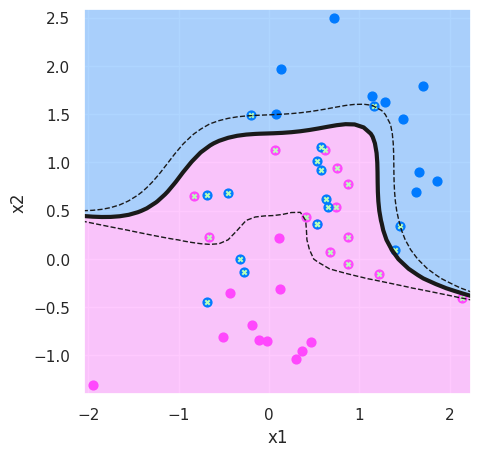

In [41]:
svm_poly_best = grid.best_estimator_

plot_boundary(X, y, svm_poly_best, 
              step_x=(0.01, 0.01),
              max_x=(0.1, 0.1),
              min_x=(-0.1, -0.1),
              colormap_frontier=('#ffb7fe', '#93c7ff'),
              colormap_points=('#ff48fd', '#007aff'),
              figsize=(5, 5),
              legend=False,
              point_size=40)
# Grafiquemos los vectores de soporte
plt.scatter(svm_poly_best.support_vectors_[:,0], svm_poly_best.support_vectors_[:,1], marker="x", color="#b8ffb7", s=10);

# Graficamos los bordes de decision
plot_svm_margins(X, svm_poly_best)

Otro tipo de función de kernel que vimos es la radial, habiamos visto en clase que teniamos el hiperparámetro gamma. Si usamos esta función en [SVC](https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html#sklearn.svm.SVC.decision_function), podemos pasar el argumento como **gamma**, al igual que el caso de kernel polinomial.

Para probar este kernel vamos a usar otro dataset sintético

In [42]:
from sklearn.model_selection import train_test_split

X = rng.standard_normal((200, 2)) 
X[:100] += 2
X[100:150] -= 2
y = np.array([1]*150+[2]*50)

(X_train, X_test, y_train, y_test) = train_test_split(X, y, stratify=y, test_size=0.5, random_state=0)

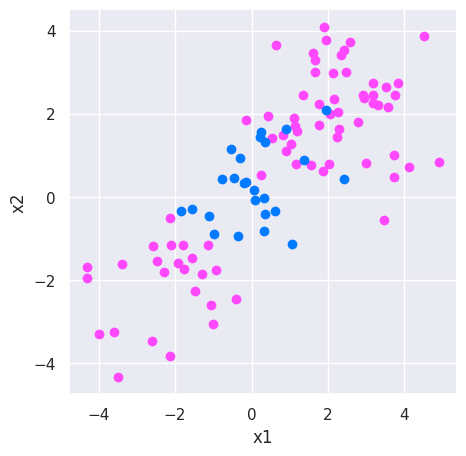

In [43]:
fig, ax = plt.subplots(figsize=(5,5)) 
ax.scatter(X_train[y_train==1][:,0], X_train[y_train==1][:,1], c="#ff48fd")
ax.scatter(X_train[y_train==2][:,0], X_train[y_train==2][:,1], c="#007aff")
ax.set_xlabel("x1")
ax.set_ylabel("x2");

Pero, vamos a realizar primero una busqueda de posibles hiperparametro, tanto para C como para gamma usando **gridsearchCV**

In [44]:
svm_kbf = SVC(kernel='rbf')

grid = GridSearchCV(svm_kbf,
                    {"C": [0.001, 0.01, 0.1, 1, 5, 10, 100],
                     "gamma": [0.5, 1, 2, 3, 4]},
                    refit=True,
                    cv=5,
                    scoring='accuracy')
grid.fit(X_train, y_train)

,estimator,SVC()
,param_grid,"{'C': [0.001, 0.01, ...], 'gamma': [0.5, 1, ...]}"
,scoring,'accuracy'
,n_jobs,None
,refit,True
,cv,5
,verbose,0
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,C,5


In [45]:
grid.best_params_

{'C': 5, 'gamma': 0.5}

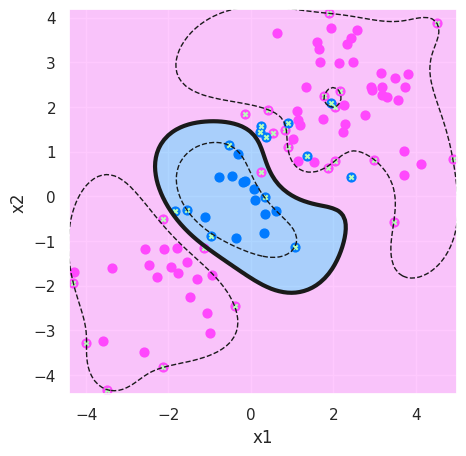

In [46]:
svm_rbf_best = grid.best_estimator_

plot_boundary(X_train, y_train, svm_rbf_best, 
              step_x=(0.01, 0.01),
              max_x=(0.1, 0.1),
              min_x=(-0.1, -0.1),
              colormap_frontier=('#ffb7fe', '#93c7ff'),
              colormap_points=('#ff48fd', '#007aff'),
              figsize=(5, 5),
              legend=False,
              point_size=40)
# Grafiquemos los vectores de soporte
plt.scatter(svm_rbf_best.support_vectors_[:,0], svm_rbf_best.support_vectors_[:,1], marker="x", color="#b8ffb7", s=10);

# Graficamos los bordes de decision
plot_svm_margins(X_train, svm_rbf_best)

Podemos evaluar el modelo con un set de testeo

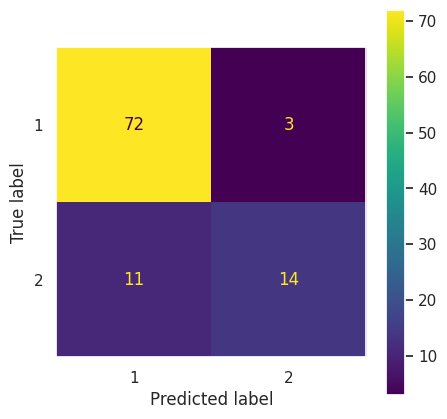

In [47]:
y_pred = svm_rbf_best.predict(X_test)

cm = confusion_matrix(y_test, y_pred, labels=svm_rbf_best.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=svm_rbf_best.classes_)

fig, ax = plt.subplots(figsize=(5,5))
ax.grid(False)
disp.plot(ax=ax);

In [48]:
print(f"El porcentaje de exactitud es de:{accuracy_score(y_test, y_pred)*100: .0f}%")

El porcentaje de exactitud es de: 86%


----

## Clasificación de multi-clase con SVM

El modelo [SVC](https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html#sklearn.svm.SVC.decision_function) implementado por sklearn nos permite realizar clasificacion de multiclase en cualquier de los dos clases que vimos en clase. Para ello tenemos el atributo *decision_function_shape* que puede tomar dos formas:

- 'ovo': Estrategia One vs one
- 'ovr': Estrategia One vs rest (One vs all).

Creemos una data sintetica para este caso:

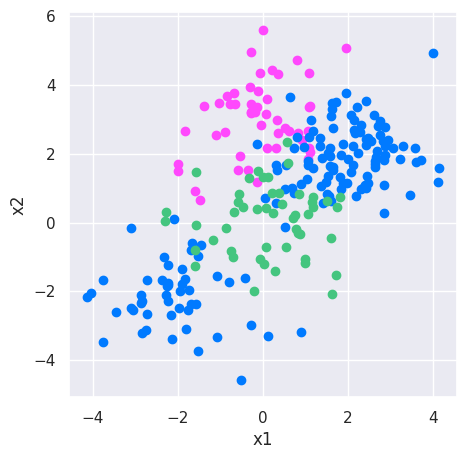

In [49]:
rng = np.random.default_rng(42)

X = rng.standard_normal((200, 2)) 
X[:100] += 2
X[100:150] -= 2
y = np.array([1]*150+[2]*50)

X = np.vstack([X, rng.standard_normal((50, 2))]) 
y = np.hstack([y, [0]*50])
X[y==0,1] += 3

fig, ax = plt.subplots(figsize=(5,5)) 
ax.scatter(X[y==0][:,0], X[y==0][:,1], c="#ff48fd")
ax.scatter(X[y==1][:,0], X[y==1][:,1], c="#007aff")
ax.scatter(X[y==2][:,0], X[y==2][:,1], c="#44c57f")
ax.set_xlabel("x1")
ax.set_ylabel("x2");

Entrenamos el modelo con un kernel RBF y una estrategia one-vs-one

In [ ]:
svm_rbf_3 = SVC(kernel="rbf", C=1, gamma=0.1, decision_function_shape='ovo', probability=True)
svm_rbf_3.fit(X, y)

,C,1
,kernel,'rbf'
,degree,3
,gamma,0.1
,coef0,0.0
,shrinking,True
,probability,True
,tol,0.001
,cache_size,200
,class_weight,None
,verbose,False


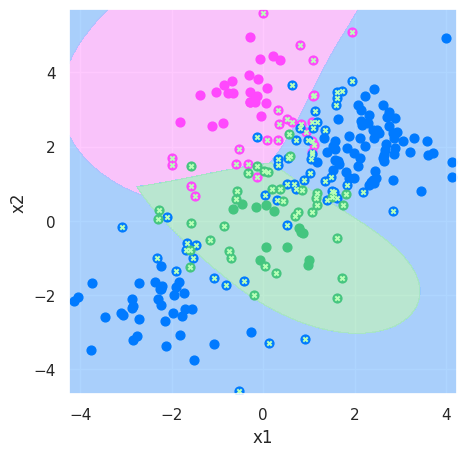

In [59]:
plot_boundary(X, y, svm_rbf_3, 
              step_x=(0.01, 0.01),
              max_x=(0.1, 0.1),
              min_x=(-0.1, -0.1),
              colormap_frontier=('#ffb7fe', '#93c7ff', "#a9e5c5"),
              colormap_points=('#ff48fd', '#007aff', "#44c57f"),
              label_point=(0, 1, 2),
              figsize=(5, 5),
              legend=False,
              point_size=40)

# Grafiquemos los vectores de soporte
plt.scatter(svm_rbf_3.support_vectors_[:,0], svm_rbf_3.support_vectors_[:,1], marker="x", color="#b8ffb7", s=10);

Para entender como se arman las zonas de decisión, veamos las fronteras de decisión:

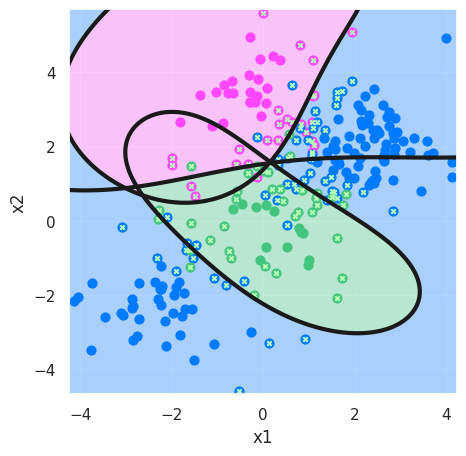

In [60]:
plot_boundary(X, y, svm_rbf_3, 
              step_x=(0.01, 0.01),
              max_x=(0.1, 0.1),
              min_x=(-0.1, -0.1),
              colormap_frontier=('#ffb7fe', '#93c7ff', "#a9e5c5"),
              colormap_points=('#ff48fd', '#007aff', "#44c57f"),
              label_point=(0, 1, 2),
              figsize=(5, 5),
              legend=False,
              point_size=40)

# Grafiquemos los vectores de soporte
plt.scatter(svm_rbf_3.support_vectors_[:,0], svm_rbf_3.support_vectors_[:,1], marker="x", color="#b8ffb7", s=10);

# Graficamos los bordes de decision
plot_svm_margins(X, svm_rbf_3, linewidths=[0, 3, 0])

----

## SVC en Heart

Para practicar con un dataset real usemos el dataset [**Heart**](https://archive.ics.uci.edu/dataset/45/heart+disease), el cual mediciones de 302 pacientes, con 13 atributos de variables fisiologicas. Además contamos con una columna de valores binarios llamada **target** que nos indica si el paciente tiene una enfermedad coronaria o no.

In [70]:
# Cargamos el dataset
df_heart = pd.read_csv("./heart.csv")

In [71]:
df_heart.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1025 entries, 0 to 1024
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1025 non-null   int64  
 1   sex       1025 non-null   int64  
 2   cp        1025 non-null   int64  
 3   trestbps  1025 non-null   int64  
 4   chol      1025 non-null   int64  
 5   fbs       1025 non-null   int64  
 6   restecg   1025 non-null   int64  
 7   thalach   1025 non-null   int64  
 8   exang     1025 non-null   int64  
 9   oldpeak   1025 non-null   float64
 10  slope     1025 non-null   int64  
 11  ca        1025 non-null   int64  
 12  thal      1025 non-null   int64  
 13  target    1025 non-null   int64  
dtypes: float64(1), int64(13)
memory usage: 112.2 KB


Este dataset en Kaggle tiene un error el cual tiene duplicados muchas veces los mismos valores. Por lo que primero quitemos los duplicados.

In [72]:
df_heart.duplicated().sum()

np.int64(723)

In [74]:
df_heart.drop_duplicates(inplace=True)

In [75]:
df_heart.target.value_counts()

target
1    164
0    138
Name: count, dtype: int64

Las clases están bastante balanceadas, voy a usar F1-Score como metrica de evaluación

In [76]:
df_heart.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,52,1,0,125,212,0,1,168,0,1.0,2,2,3,0
1,53,1,0,140,203,1,0,155,1,3.1,0,0,3,0
2,70,1,0,145,174,0,1,125,1,2.6,0,0,3,0
3,61,1,0,148,203,0,1,161,0,0.0,2,1,3,0
4,62,0,0,138,294,1,1,106,0,1.9,1,3,2,0


Se realiza one-hot encoding de ciertas variables porque pueden tomar muchos valores.

In [82]:
# Hacemos variable dummy a las categoricas
categorical_features = ["cp", "restecg", "slope", "ca", "thal"]

df_heart_dummies = pd.get_dummies(data=df_heart, 
                                  columns=categorical_features, 
                                  drop_first=True)

In [83]:
df_heart_dummies.columns

Index(['age', 'sex', 'trestbps', 'chol', 'fbs', 'thalach', 'exang', 'oldpeak',
       'target', 'cp_1', 'cp_2', 'cp_3', 'restecg_1', 'restecg_2', 'slope_1',
       'slope_2', 'ca_1', 'ca_2', 'ca_3', 'ca_4', 'thal_1', 'thal_2',
       'thal_3'],
      dtype='object')

---
Trabajemos en el modelo

Todas las variables son numericas, por lo que no debemos hacer nada para adaptarlas, mas que normalizarlas. Para este caso vamos a usar todos los atributos.

In [85]:
X = df_heart_dummies.drop(columns='target')
y = df_heart.iloc[:, -1]

In [86]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42)

In [87]:
from sklearn.preprocessing import StandardScaler

sc_X = StandardScaler()
X_train = sc_X.fit_transform(X_train)
X_test = sc_X.transform(X_test)

Vamos a hacer una busqueda de grilla para buscar que modelo se ajustaria mejor.

In [88]:
svm_hearth = SVC()

grid = GridSearchCV(svm_hearth,
                    [{"C": [0.01, 0.1, 1, 5, 10, 100], "kernel": ["linear"]},
                     {"C": [0.01, 0.1, 1, 5, 10, 100], "gamma": [0.1, 0.5, 1, 2, 10, 100], "kernel": ["rbf"]},
                     {"C": [0.01, 0.1, 1, 5, 10, 100], "degree": [2, 3, 4, 5, 6], "kernel": ["poly"]}],
                    refit=True,
                    cv=5,
                    scoring='f1')
grid.fit(X_train, y_train)

,estimator,SVC()
,param_grid,"[{'C': [0.01, 0.1, ...], 'kernel': ['linear']}, {'C': [0.01, 0.1, ...], 'gamma': [0.1, 0.5, ...], 'kernel': ['rbf']}, ...]"
,scoring,'f1'
,n_jobs,None
,refit,True
,cv,5
,verbose,0
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,C,5


In [89]:
grid.best_params_

{'C': 5, 'kernel': 'linear'}

📝 Que el kernel sea lineal, significa que el problema es mas o menos linealmente separable. El problema es facil de resolver.

Elegido el mejor modelo y entrenado, podemos ver el estado

In [90]:
svm_hearth_best = grid.best_estimator_

Y podemos ver que diferentes métricas que nos dio con el dataset de testeo

In [92]:
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score

y_pred = svm_hearth_best.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print(f"La exactitud de clasificación es: {accuracy}")
print(f"Precisión de testeo fue: {precision}")
print(f"Recall de testeo fue: {recall}")
print(f"F1-score de testeo fue: {f1}")

La exactitud de clasificación es: 0.8571428571428571
Precisión de testeo fue: 0.8
Recall de testeo fue: 0.9302325581395349
F1-score de testeo fue: 0.8602150537634409


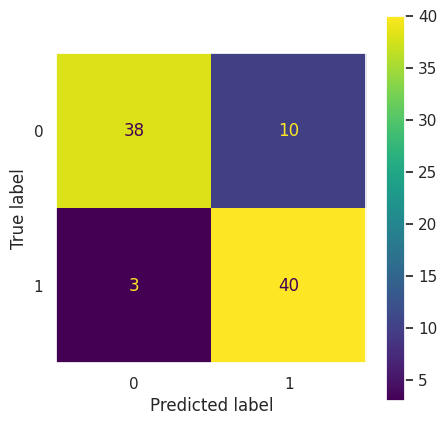

In [93]:
cm = confusion_matrix(y_test, y_pred, labels=svm_hearth_best.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=svm_hearth_best.classes_)

fig, ax = plt.subplots(figsize=(5,5))
ax.grid(False)
disp.plot(ax=ax);

Algo que podemos hacer con los SVM es obtener la curva ROC

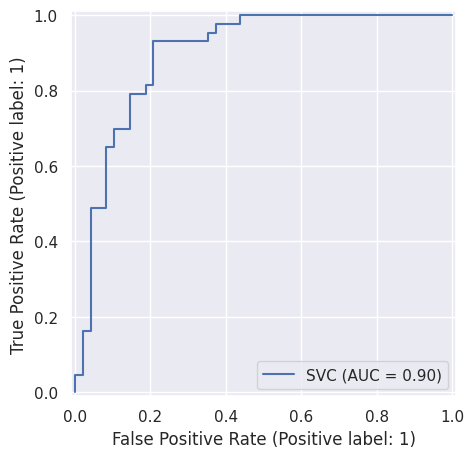

In [94]:
from sklearn.metrics import RocCurveDisplay
    
fig, ax = plt.subplots(figsize=(5,5))
svc_disp = RocCurveDisplay.from_estimator(svm_hearth_best, X_test, y_test, ax=ax)

plt.show();

Como vemos el clasificador SVC para este dataset nos dio un valor bastante alto de AUC (0.90 aprox).

En un contexto clinico/medico, lo que se busca es minimizar los falsos negativos (mejorar el recall).

----

## SVM como regresión

Como vimos en clase, SVM tambien se puede usar para realizar regresiones. Scikit-learn nos ofrece la clase [SVR](https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVR.html#sklearn.svm.SVR) que es la implementación de SVM para regresión. 

Para practicar este modelo, vamos a usar el dataset **Hitters**, el cual contiene datos de jugadores de beisbol de la liga estadounidense de 1986 y 1987. Contiene 322 observaciones con 20 datos. Este conjunto de datos se tomó de la biblioteca StatLib que se mantiene en la Universidad Carnegie Mellon. Los datos salariales fueron originalmente de Sports Illustrated, 20 de abril de 1987. Las estadísticas de 1986 y de carrera se obtuvieron de The 1987 Baseball Encyclopedia Update publicado por Collier Books, Macmillan Publishing Company, Nueva York. Que significa cada cosa está [explicado aqui](https://rdrr.io/cran/ISLR/man/Hitters.html).

Lo que queremos hacer es tener alguna regresión de los salarios de 1987 los jugadores usando como base los datos de ellos de su perfomance en 1986.

In [95]:
# Cargamos el dataset
df_hitters = pd.read_csv("./Hitters.csv")

In [96]:
df_hitters.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 322 entries, 0 to 321
Data columns (total 20 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   AtBat      322 non-null    int64  
 1   Hits       322 non-null    int64  
 2   HmRun      322 non-null    int64  
 3   Runs       322 non-null    int64  
 4   RBI        322 non-null    int64  
 5   Walks      322 non-null    int64  
 6   Years      322 non-null    int64  
 7   CAtBat     322 non-null    int64  
 8   CHits      322 non-null    int64  
 9   CHmRun     322 non-null    int64  
 10  CRuns      322 non-null    int64  
 11  CRBI       322 non-null    int64  
 12  CWalks     322 non-null    int64  
 13  League     322 non-null    object 
 14  Division   322 non-null    object 
 15  PutOuts    322 non-null    int64  
 16  Assists    322 non-null    int64  
 17  Errors     322 non-null    int64  
 18  Salary     263 non-null    float64
 19  NewLeague  322 non-null    object 
dtypes: float64

In [97]:
df_hitters.describe()

,AtBat,Hits,HmRun,Runs,RBI,Walks,Years,CAtBat,CHits,CHmRun,CRuns,CRBI,CWalks,PutOuts,Assists,Errors,Salary
count,322.000000,322.000000,322.000000,322.000000,322.000000,322.000000,322.000000,322.00000,322.000000,322.000000,322.000000,322.000000,322.000000,322.000000,322.000000,322.000000,263.000000
mean,380.928571,101.024845,10.770186,50.909938,48.027950,38.742236,7.444099,2648.68323,717.571429,69.490683,358.795031,330.118012,260.239130,288.937888,106.913043,8.040373,535.925882
std,153.404981,46.454741,8.709037,26.024095,26.166895,21.639327,4.926087,2324.20587,654.472627,86.266061,334.105886,333.219617,267.058085,280.704614,136.854876,6.368359,451.118681
min,16.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,19.00000,4.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,67.500000
25%,255.250000,64.000000,4.000000,30.250000,28.000000,22.000000,4.000000,816.75000,209.000000,14.000000,100.250000,88.750000,67.250000,109.250000,7.000000,3.000000,190.000000
50%,379.500000,96.000000,8.000000,48.000000,44.000000,35.000000,6.000000,1928.00000,508.000000,37.500000,247.000000,220.500000,170.500000,212.000000,39.500000,6.000000,425.000000
75%,512.000000,137.000000,16.000000,69.000000,64.750000,53.000000,11.000000,3924.25000,1059.250000,90.000000,526.250000,426.250000,339.250000,325.000000,166.000000,11.000000,750.000000
max,687.000000,238.000000,40.000000,130.000000,121.000000,105.000000,24.000000,14053.00000,4256.000000,548.000000,2165.000000,1659.000000,1566.000000,1378.000000,492.000000,32.000000,2460.000000


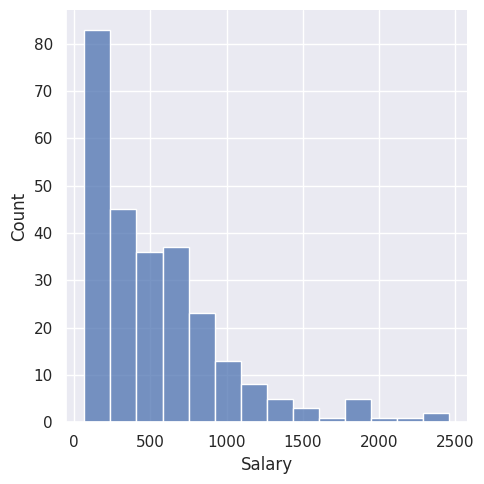

In [99]:
sns.displot(df_hitters['Salary'])
plt.show()

In [100]:
# Como los datos de salario no están completos, descartamos a aquellos jugadores que no tienen ese dato.
df_hitters.dropna(subset="Salary", inplace=True)

In [101]:
# Aplico feature engineering, modificando el target por el logaritmo
df_hitters["Salary_log"] = np.log1p(df_hitters["Salary"])

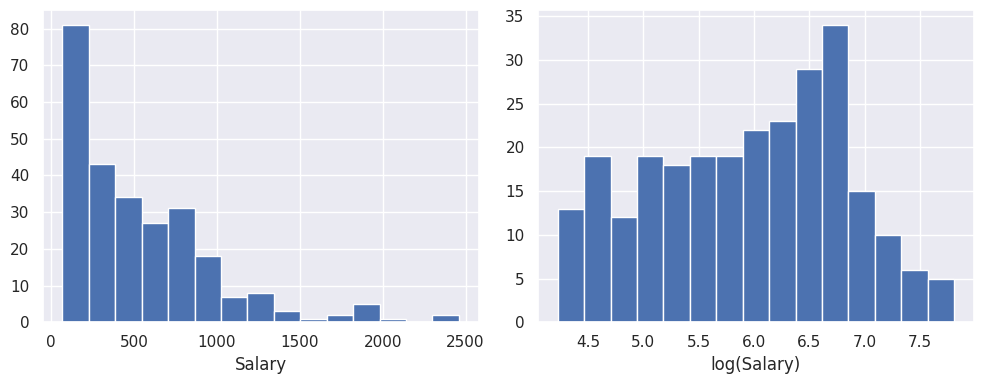

In [102]:
f, ax = plt.subplots(1,2, figsize=(10, 4))
df_hitters["Salary"].hist(ax=ax[0], bins=15)
df_hitters["Salary_log"].hist(ax=ax[1], bins=15)

ax[0].set_xlabel("Salary")
ax[1].set_xlabel("log(Salary)")
plt.tight_layout()

Como podemos ver, mejoramos la dispersion de datos, principalmente aquellos que estan en los primeros bins.

Tenemos todas variables numericas, menos *League*, *Division* y *NewLeague*, que vamos a obtener las variables dummy de ellas:

In [103]:
df_hitters.League.value_counts()

League
A    139
N    124
Name: count, dtype: int64

In [104]:
df_hitters.Division.value_counts()

Division
W    134
E    129
Name: count, dtype: int64

In [105]:
df_hitters.NewLeague.value_counts()

NewLeague
A    141
N    122
Name: count, dtype: int64

In [106]:
df_hitters_dummies = pd.get_dummies(data=df_hitters, 
                                    columns=['League', 'Division', 'NewLeague'],
                                    drop_first=True)

In [107]:
df_hitters_dummies.columns

Index(['AtBat', 'Hits', 'HmRun', 'Runs', 'RBI', 'Walks', 'Years', 'CAtBat',
       'CHits', 'CHmRun', 'CRuns', 'CRBI', 'CWalks', 'PutOuts', 'Assists',
       'Errors', 'Salary', 'Salary_log', 'League_N', 'Division_W',
       'NewLeague_N'],
      dtype='object')

Obtenemos los arrays

In [108]:
X_cols = ['AtBat', 'Hits', 'HmRun', 'Runs', 'RBI', 'Walks', 'Years', 'CAtBat', 'CHits', 
          'CHmRun', 'CRuns', 'CRBI', 'CWalks', 'PutOuts', 'Assists', 'Errors', 'League_N', 
          'Division_W', 'NewLeague_N']

X = df_hitters_dummies.loc[:, X_cols]
# Y como variable a predecir a Salary
y = df_hitters_dummies.loc[:, 'Salary_log']

Separamos en el dataset de entrenamiento y testeo

In [109]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

Ahora escalamos a las variables

In [110]:
sc_X = StandardScaler()
X_train = sc_X.fit_transform(X_train)
X_test = sc_X.transform(X_test)

Vamos a realizar otra busqueda de hiperparametros para evaluar el modelo, nada mas que ahora como metrica vamos a usar MAE, dado que estamos en un caso de regresión:

In [111]:
from sklearn.svm import SVR

svm_hitters = SVR()

grid = GridSearchCV(svm_hitters,
                    [{"C": [0.01, 0.1, 1, 5, 10, 100], "kernel": ["linear"]},
                     {"C": [0.01, 0.1, 1, 5, 10, 100], "gamma": [0.1, 0.5, 1, 2, 10, 100], "kernel": ["rbf", "sigmoid"]},
                     {"C": [0.01, 0.1, 1, 5, 10, 100], "degree": [2, 3, 4, 5, 6], "kernel": ["poly"]}],
                    refit=True,
                    cv=5,
                    scoring='neg_mean_absolute_error')
grid.fit(X_train,y_train)

,estimator,SVR()
,param_grid,"[{'C': [0.01, 0.1, ...], 'kernel': ['linear']}, {'C': [0.01, 0.1, ...], 'gamma': [0.1, 0.5, ...], 'kernel': ['rbf', 'sigmoid']}, ...]"
,scoring,'neg_mean_absolute_error'
,n_jobs,None
,refit,True
,cv,5
,verbose,0
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,kernel,'rbf'


In [112]:
grid.best_params_

{'C': 10, 'gamma': 0.1, 'kernel': 'rbf'}

Según esta busqueda el mejor modelo es uno con función radial.

Evaluemos este modelo con el set de testeo.

In [113]:
from sklearn.metrics import (mean_absolute_error, r2_score,
                             root_mean_squared_error, 
                             mean_absolute_percentage_error)

svm_hitters_best = grid.best_estimator_

y_pred = svm_hitters_best.predict(X_test)

mae = mean_absolute_error(y_test, y_pred)
rmse = root_mean_squared_error(y_test, y_pred)
mape = mean_absolute_percentage_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"MAE de testeo fue: {mae}")
print(f"RMSE de testeo fue: {rmse}")
print(f"MAPE de testeo fue: {mape}")
print(f"R2 de testeo fue: {r2}")

MAE de testeo fue: 0.390431462442625
RMSE de testeo fue: 0.5683077311871718
MAPE de testeo fue: 0.06799871402024425
R2 de testeo fue: 0.5826895866382031


Este modelo tuvo un error de testeo de 0.39. 

Comparemos este modelo con una regresión Ridge, la cual primero hacemos una busqueda de hiperparámetros:

In [114]:
from sklearn.linear_model import Ridge

ridge_hitters = Ridge()

grid = GridSearchCV(ridge_hitters,
                    {"alpha": np.linspace(0, 20, 1000)},
                    refit=True,
                    cv=5,
                    scoring='neg_mean_absolute_error')
grid.fit(X_train,y_train)

,estimator,Ridge()
,param_grid,{'alpha': array([ 0. ... 20. ])}
,scoring,'neg_mean_absolute_error'
,n_jobs,None
,refit,True
,cv,5
,verbose,0
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,alpha,np.float64(15.035035035035035)


In [115]:
grid.best_params_

{'alpha': np.float64(15.035035035035035)}

In [116]:
ridge_hitters = grid.best_estimator_

y_pred = ridge_hitters.predict(X_test)

mae = mean_absolute_error(y_test, y_pred)
rmse = root_mean_squared_error(y_test, y_pred)
mape = mean_absolute_percentage_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"MAE de testeo fue: {mae}")
print(f"RMSE de testeo fue: {rmse}")
print(f"MAPE de testeo fue: {mape}")
print(f"R2 de testeo fue: {r2}")

MAE de testeo fue: 0.5097831521314252
RMSE de testeo fue: 0.659897248144203
MAPE de testeo fue: 0.08994436062860377
R2 de testeo fue: 0.4373417018481742


Vemos que la regresión SVR que armamos mejoró un 23% con respecto a la regresión de Ridge.

# Extra: Optimización bayesiana

Temporary directory for frames: ./tmp
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds fo

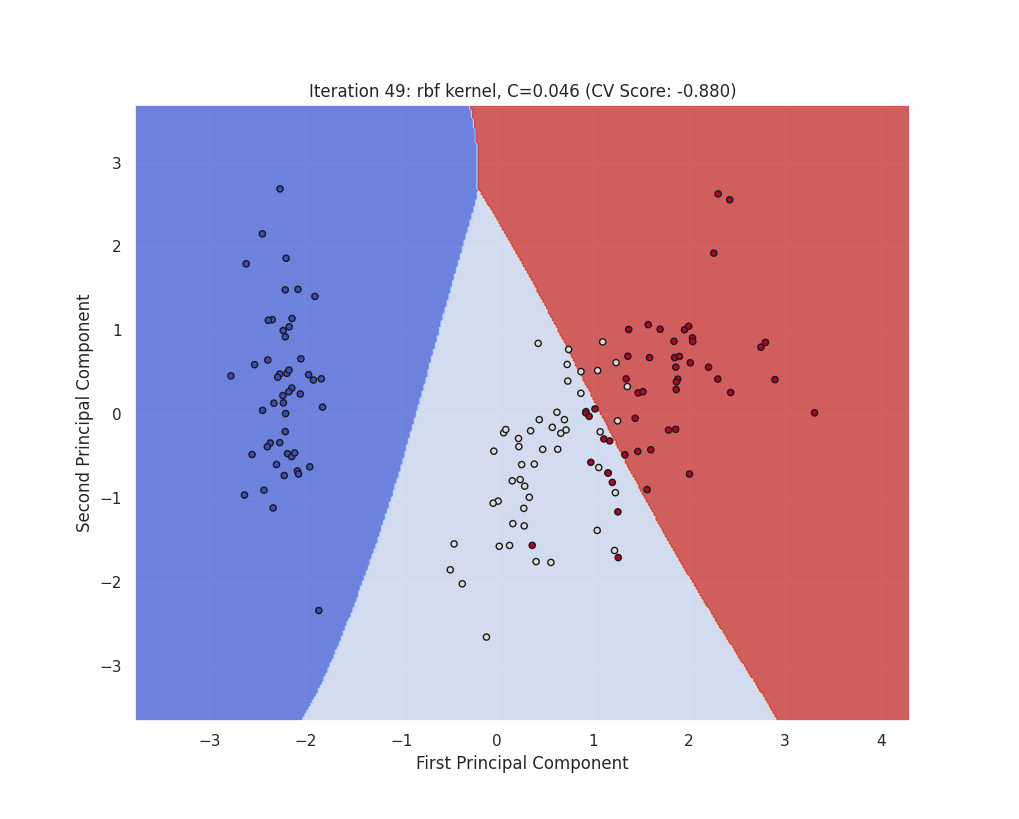

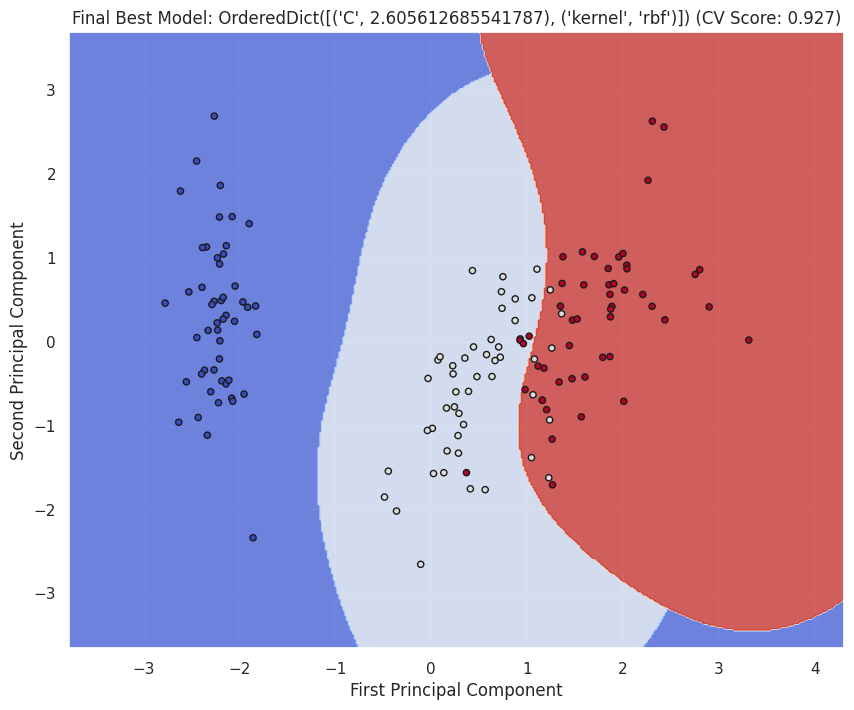


Summary of optimization steps:
Step 0: kernel=rbf, C=4.107, score=-0.920
Step 1: kernel=rbf, C=8.376, score=-0.907
Step 2: kernel=rbf, C=8.376, score=-0.907
Step 3: kernel=rbf, C=8.376, score=-0.907
Step 4: kernel=rbf, C=8.376, score=-0.907
Step 5: kernel=rbf, C=8.376, score=-0.907
Step 6: kernel=rbf, C=8.376, score=-0.907
Step 7: kernel=rbf, C=8.376, score=-0.907
Step 8: kernel=rbf, C=8.376, score=-0.907
Step 9: kernel=rbf, C=0.046, score=-0.880
Step 10: kernel=rbf, C=0.046, score=-0.880
Step 11: kernel=rbf, C=0.046, score=-0.880
Step 12: kernel=rbf, C=0.046, score=-0.880
Step 13: kernel=rbf, C=0.046, score=-0.880
Step 14: kernel=rbf, C=0.046, score=-0.880
Step 15: kernel=rbf, C=0.046, score=-0.880
Step 16: kernel=rbf, C=0.046, score=-0.880
Step 17: kernel=rbf, C=0.046, score=-0.880
Step 18: kernel=rbf, C=0.046, score=-0.880
Step 19: kernel=rbf, C=0.046, score=-0.880
Step 20: kernel=rbf, C=0.046, score=-0.880
Step 21: kernel=rbf, C=0.046, score=-0.880
Step 22: kernel=rbf, C=0.046, sc

In [118]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import datasets, svm
from sklearn.decomposition import PCA
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.preprocessing import StandardScaler
from skopt import BayesSearchCV
from skopt.space import Real, Categorical, Integer
import matplotlib.animation as animation
import os

def make_meshgrid(x, y, h=.02):
    """Create a mesh of points to plot in
    
    Parameters
    ----------
    x: data to base x-axis meshgrid on
    y: data to base y-axis meshgrid on
    h: stepsize for meshgrid, optional
    
    Returns
    -------
    xx, yy : ndarray
    """
    x_min, x_max = x.min() - 1, x.max() + 1
    y_min, y_max = y.min() - 1, y.max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
    return xx, yy

def plot_contours(ax, clf, xx, yy, **params):
    """Plot the decision boundaries for a classifier.
    
    Parameters
    ----------
    ax: matplotlib axes object
    clf: a classifier
    xx: meshgrid ndarray
    yy: meshgrid ndarray
    params: dictionary of params to pass to contourf, optional
    """
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    out = ax.contourf(xx, yy, Z, **params)
    return out

class OptimizationCallback:
    def __init__(self, X, y, X_mesh, temp_dir):
        self.X = X
        self.y = y
        self.X_mesh = X_mesh
        self.temp_dir = temp_dir
        self.iteration = 0
        self.results = []
        
    def __call__(self, res):
        # Extract the best parameters so far
        best_idx = np.argmax(res.func_vals)
        
        # Get parameter values and names
        C_val = res.x_iters[best_idx][0]
        kernel_val = res.x_iters[best_idx][1]
        
        # Create parameter dict based on kernel type
        if kernel_val == 'linear':
            param_dict = {
                'C': C_val,
                'kernel': kernel_val
            }
        elif kernel_val == 'poly':
            param_dict = {
                'C': C_val,
                'kernel': kernel_val,
            }
        elif kernel_val == 'rbf':
            param_dict = {
                'C': C_val,
                'kernel': kernel_val,
            }
        else:
            # Default case
            param_dict = {
                'C': C_val,
                'kernel': kernel_val
            }
        
        # Create and fit a model with these parameters
        model = svm.SVC(**param_dict)
        model.fit(self.X, self.y)
        
        # Also store full parameter values for visualization
        full_params = {
            'C': C_val,
            'kernel': kernel_val,
        }
        
        # Save parameters and score
        self.results.append({
            'params': param_dict,
            'full_params': full_params,
            'score': max(res.func_vals),
            'model': model
        })
        
        # Create a plot for this iteration
        fig, ax = plt.subplots(figsize=(10, 8))
        
        # Plot decision boundary
        xx, yy = self.X_mesh
        plot_contours(ax, model, xx, yy, cmap=plt.cm.coolwarm, alpha=0.8)
        
        # Plot data points
        X0, X1 = self.X[:, 0], self.X[:, 1]
        ax.scatter(X0, X1, c=self.y, cmap=plt.cm.coolwarm, s=20, edgecolors='k')
        
        # Set plot labels and title
        ax.set_xlim(xx.min(), xx.max())
        ax.set_ylim(yy.min(), yy.max())
        ax.set_xlabel('First Principal Component')
        ax.set_ylabel('Second Principal Component')
        title = f"Iteration {self.iteration}: {kernel_val} kernel, C={C_val:.3f}"
        title += f" (CV Score: {max(res.func_vals):.3f})"
        ax.set_title(title)
        
        # Save the figure
        plt.savefig(os.path.join(self.temp_dir, f"iteration_{self.iteration:03d}.png"))
        plt.close(fig)
        
        self.iteration += 1
        return False  # Don't stop optimization

# Load and prepare data
iris = datasets.load_iris()
X = iris.data
y = iris.target

# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Apply PCA to reduce to 2 dimensions for visualization
pca = PCA(n_components=2)
X_reduced = pca.fit_transform(X_scaled)

# Split data for later testing
X_train, X_test, y_train, y_test = train_test_split(X_reduced, y, test_size=0.2, random_state=42)

# Create temporary directory for storing the frames
if not os.path.isdir('./tmp'):
    os.mkdir('./tmp')
temp_dir = './tmp'
print(f"Temporary directory for frames: {temp_dir}")

# Prepare mesh grid for visualization
X0, X1 = X_reduced[:, 0], X_reduced[:, 1]
xx, yy = make_meshgrid(X0, X1)
mesh_grid = (xx, yy)

# Create the callback
callback = OptimizationCallback(X_reduced, y, mesh_grid, temp_dir)

# Define the search space for Bayesian optimization
search_spaces = {
    'C': Real(0.01, 10, prior='uniform'),
    'kernel': Categorical(['linear', 'poly', 'rbf']),
}

# Set up the Bayesian optimization with cross-validation
opt = BayesSearchCV(
    svm.SVC(),  # Removed probability=True which isn't needed for classification
    search_spaces,
    n_iter=50,  # Number of optimization iterations
    cv=5,       # 5-fold cross-validation
    n_jobs=1,   # Use 1 core to avoid parallelism issues with the callback
    random_state=42,
    verbose=1
)

# Run the optimization with the callback
opt.fit(X_reduced, y, callback=[callback])

# Print the best hyperparameters
print("Best parameters:", opt.best_params_)
print("Best cross-validation score: {:.3f}".format(opt.best_score_))
print("Test set score: {:.3f}".format(opt.score(X_test, y_test)))

# Create the GIF from the saved frames
images = []
for i in range(callback.iteration):
    filename = os.path.join(temp_dir, f"iteration_{i:03d}.png")
    if os.path.exists(filename):  # Make sure the file exists
        images.append(plt.imread(filename))

if images:
    # Create GIF using animation
    fig, ax = plt.subplots(figsize=(10, 8))
    plt.axis('off')  # Turn off axis

    frames = []
    for img in images:
        frame = ax.imshow(img, animated=True)
        ax.set_position([0, 0, 1, 1])  # Make the figure fill the entire figure
        frames.append([frame])

    ani = animation.ArtistAnimation(fig, frames, interval=1000, blit=True)

    # Save the animation
    gif_path = os.path.join(temp_dir, "bayesian_optimization_svm.gif")
    ani.save(gif_path, writer='pillow', fps=1)
    print(f"GIF saved at: {gif_path}")
else:
    print("No images were found to create a GIF. Check if the callback generated any frames.")

# Display the best model results
# Create a clean version of the best parameters for fitting
best_params = opt.best_params_.copy()

best_model = svm.SVC(**best_params)
best_model.fit(X_reduced, y)

plt.figure(figsize=(10, 8))
plot_contours(plt.gca(), best_model, xx, yy, cmap=plt.cm.coolwarm, alpha=0.8)
plt.scatter(X0, X1, c=y, cmap=plt.cm.coolwarm, s=20, edgecolors='k')
plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())
plt.xlabel('First Principal Component')
plt.ylabel('Second Principal Component')
plt.title(f"Final Best Model: {opt.best_params_} (CV Score: {opt.best_score_:.3f})")
plt.savefig(os.path.join(temp_dir, "final_best_model.png"))
plt.show()

print("\nSummary of optimization steps:")
for i, result in enumerate(callback.results):
    params = result['full_params']
    kernel = params['kernel']
    print(f"Step {i}: kernel={kernel}, C={params['C']:.3f}, ", end="")
    print(f"score={result['score']:.3f}")

print("\nIf running in a notebook environment, display the GIF:")
print("from IPython.display import Image")
print(f"Image(filename='{gif_path}')")